**Objective**: Exploring methods for building a model for identifying eating activity in Capture24

In [81]:
import os
import numpy as np
import pandas as pd
from glob import glob
import scipy.stats as stats
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from joblib import Parallel, delayed
import urllib
import shutil
from tqdm.auto import tqdm
import utils  # helper functions -- check out utils.py
import zipfile
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
# For reproducibility
np.random.seed(42)

### Load data

In [5]:
def load_all_and_make_windows(datafiles, N=999):

    def worker(datafile):
        X, Y, T = utils.make_windows(utils.load_data(datafile), winsec=30)
        pid = os.path.basename(datafile).split(".")[0]  # participant ID
        pid = np.asarray([pid] * len(X))
        return X, Y, T, pid

    results = Parallel(n_jobs=4)(
        delayed(worker)(datafile) for datafile in tqdm(datafiles[:N])
    )

    X = np.concatenate([result[0] for result in results])
    Y = np.concatenate([result[1] for result in results])
    T = np.concatenate([result[2] for result in results])
    pid = np.concatenate([result[3] for result in results])

    return X, Y, T, pid

In [6]:
# get all accelerometer data files

datafiles = os.path.expanduser("~/capture24/accelerometer/P[0-9][0-9][0-9].csv.gz")
X, Y, T, pid = load_all_and_make_windows(glob(datafiles))

# save the arrays for later
outputpath = os.path.expanduser("~/eating_detect/data/")
os.makedirs(outputpath + "processed_data/", exist_ok=True)
np.save(outputpath + "processed_data/X.npy", X)
np.save(outputpath + "processed_data/Y.npy", Y)
np.save(outputpath + "processed_data/T.npy", T)
np.save(outputpath + "processed_data/pid.npy", pid)


  0%|          | 0/151 [00:00<?, ?it/s]

In [2]:
# Load processed files
outputpath = os.path.expanduser("~/eating_detect/data/")
X = np.load(outputpath + 'processed_data/X.npy', mmap_mode='r')
Y = np.load(outputpath + 'processed_data/Y.npy')
T = np.load(outputpath + 'processed_data/T.npy')
pid = np.load(outputpath + 'processed_data/pid.npy')


In [184]:
X[1].shape[0]

3000

In [193]:
def extract_features(xyz):
    ''' Extract features. xyz is an array of shape (N,3) '''

    feats = {}
    feats['xMean'], feats['yMean'], feats['zMean'] = np.mean(xyz, axis=0)
    feats['xStd'], feats['yStd'], feats['zStd'] = np.std(xyz, axis=0)
    v = np.linalg.norm(xyz, axis=1)  # magnitude stream
    feats['mean'], feats['std'] = np.mean(v), np.std(v)

    # auto correlation
    num_rows, num_columns = xyz.shape
    axis_names = ['X', 'Y', 'Z']
    for col in range(num_columns):
        time_series = xyz[:, col]
        variance = time_series.var()
        mean_centered = time_series - time_series.mean()
        autocorr_full = np.correlate(mean_centered, mean_centered, mode='full')
        feats['autocor'+ axis_names[col]] = np.mean(autocorr_full)

    # cross correlation
    for i in range(num_columns):
        for j in range(i+1, num_columns):
            feats['crosscor'+ axis_names[i] + axis_names[j]] = np.correlate(xyz[:, i], xyz[:, j])
    return feats

# Extract features
X_feats = pd.DataFrame(Parallel(n_jobs=4)(delayed(extract_features)(x) for x in tqdm(X)))
X_feats.to_pickle(outputpath + 'processed_data/X_feats.pkl')
print(X_feats)


  0%|          | 0/312730 [00:00<?, ?it/s]

           xMean     yMean     zMean      xStd      yStd      zStd      mean  \
0      -0.472182 -0.534437  0.655677  0.006469  0.006348  0.003302  0.968795   
1      -0.475536 -0.531443  0.656365  0.007745  0.004139  0.002418  0.969249   
2      -0.477615 -0.530214  0.656677  0.007741  0.004491  0.003096  0.969811   
3      -0.478286 -0.530208  0.656646  0.007620  0.004762  0.003020  0.970119   
4      -0.477083 -0.530458  0.656750  0.007806  0.004137  0.003163  0.969732   
...          ...       ...       ...       ...       ...       ...       ...   
312725  0.108823  0.343010  0.813089  0.004272  0.003462  0.005327  0.889182   
312726  0.109135  0.342750  0.813104  0.003862  0.003888  0.005163  0.889134   
312727  0.108943  0.342651  0.813172  0.003960  0.004016  0.005083  0.889135   
312728  0.109828  0.342396  0.812891  0.004674  0.005394  0.005798  0.888900   
312729  0.109615  0.342552  0.813000  0.003904  0.004235  0.005030  0.889022   

             std      autocorX      aut

In [3]:
# Let's map the text annotations to simplified labels
eat_indices = np.array([index for index, element in enumerate(Y) if 'eat' in element])

# Let's load the dictionary that maps the text labels to simplified labels
# and apply it to the Y array

# Load the dictionary
label_dict_path = os.path.expanduser("~/capture24/annotation-label-dictionary.csv")
anno_label_dict = pd.read_csv(
    label_dict_path,
    index_col='annotation', 
    dtype='string'
)

# remove the last bit of string after the last ";" in Y
#pattern = ";MET\ .*"
#Y = np.array([re.sub(pattern, '', element) for element in Y])


# apply the dictionary to simplify the labels
Y_simple = np.array([anno_label_dict.loc[y, 'label:Willetts2018'] for y in Y])


In [4]:
# get the unique labels related to eating
eating_labels = np.unique(Y[eat_indices])

# write the eating labels to a file for manual inspection
with open(outputpath + 'eating_labels.txt', 'w') as f:
    for item in eating_labels:
        f.write("%s\n" % item)

In [169]:
# after inspection, I have manually created a dictionary that maps the eating labels to
# simplified labels

eating_label_dict_path = os.path.expanduser("~/eating_detect/data/eating_labels_simple.tsv")
eating_label_dict = pd.read_csv(
    eating_label_dict_path,
    sep='\t',
    dtype='string'
)

# modify the Y_simple array to add eating-specific labels
# only replace with eating and maybe-eating lables, and ignore not-eating labels
Y_simple_eating = np.copy(Y_simple).astype('U12')
for i in eat_indices:
    label = Y[i]
    eating_label = eating_label_dict.loc[label, 'simple']
    if eating_label == 'eating':
        Y_simple_eating[i] = eating_label
# the frequency of eating lables
pd.Series(Y_simple_eating).value_counts()



sleep        118802
sit-stand    111261
mixed         39398
walking       19971
vehicle       11580
eating         8728
bicycling      2990
Name: count, dtype: int64

In [170]:
# now let's read the features extracted from the accelerometer data
X_feats = pd.read_pickle(outputpath + 'processed_data/X_feats.pkl')

In [187]:
# Hold out participants P101-P151 for testing (51 participants)
test_ids = [f'P{i}' for i in range(101,152)]
mask_test = np.isin(pid, test_ids)
mask_train = ~mask_test
X_train, Y_train, T_train, pid_train = \
    X_feats[mask_train], Y_simple_eating[mask_train], T[mask_train], pid[mask_train]
X_test, Y_test, T_test, pid_test = \
    X_feats[mask_test], Y_simple_eating[mask_test], T[mask_test], pid[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (237106, 11)
Shape of X_test: (75624, 11)


### Train a random forest classifier

In [188]:
# Argument oob_score=True to be used for HMM smoothing (see later below)
clf = BalancedRandomForestClassifier(
    n_estimators=100,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf.fit(X_train, Y_train)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.0s finished
/users/doherty/imh310/miniconda3/envs/eating_detect/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:813: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


BalancedRandomForestClassifier(n_jobs=4, oob_score=True, random_state=42,
                               replacement=True,
                               sampling_strategy='not minority', verbose=1)

### Model performance


In [173]:
import importlib
importlib.reload(utils)

<module 'utils' from '/gpfs3/well/doherty/users/imh310/eating_detect/github/utils.py'>

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished



Classifier performance
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.19      0.87      0.31       374
      eating       0.12      0.50      0.19      2135
       mixed       0.47      0.42      0.44      9465
   sit-stand       0.77      0.48      0.59     28286
       sleep       0.92      0.87      0.89     27416
     vehicle       0.22      0.41      0.29      2770
     walking       0.38      0.57      0.45      5178

    accuracy                           0.62     75624
   macro avg       0.44      0.59      0.45     75624
weighted avg       0.72      0.62      0.65     75624



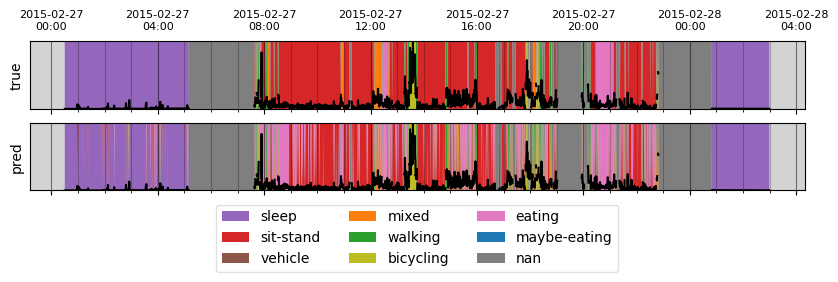

In [189]:
Y_test_pred = clf.predict(X_test)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred))

# Check again participant
mask = pid_test == 'P101'
fig, axs = utils.plot_compare(T_test[mask],
                              Y_test[mask],
                              Y_test_pred[mask],
                              trace=X_test.loc[mask, 'std'])
fig.show()


### Rolling mode smoothing

In [190]:
def mode(alist):
    ''' Mode of a list, but return middle element if ambiguous '''
    m, c = stats.mode(alist)
    m, c = m.item(), c.item()
    if c==1:
        return alist[len(alist)//2]
    return m

def rolling_mode(t, y, window_size='100S'):
    y_dtype_orig = y.dtype
    # Hack to make it work with pandas.Series.rolling()
    y = pd.Series(y, index=t, dtype='category')
    y_code_smooth = y.cat.codes.rolling(window_size).apply(mode, raw=True).astype('int')
    y_smooth = pd.Categorical.from_codes(y_code_smooth, dtype=y.dtype)
    y_smooth = np.asarray(y_smooth, dtype=y_dtype_orig)
    return y_smooth



Classifier performance -- mode smoothing
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.20      0.89      0.32       374
      eating       0.13      0.57      0.21      2135
       mixed       0.50      0.48      0.49      9465
   sit-stand       0.80      0.51      0.63     28286
       sleep       0.94      0.90      0.92     27416
     vehicle       0.29      0.40      0.34      2770
     walking       0.40      0.55      0.46      5178

    accuracy                           0.65     75624
   macro avg       0.47      0.61      0.48     75624
weighted avg       0.74      0.65      0.68     75624



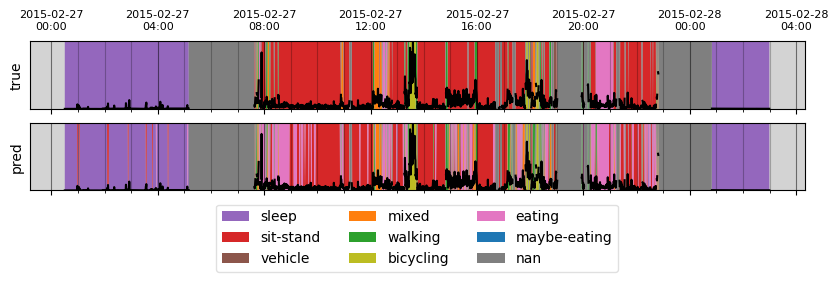

In [191]:
# Smooth the predictions of each participant
Y_test_pred_smooth = []
unqP, indP = np.unique(pid_test, return_index=True)
unqP = unqP[np.argsort(indP)]  # keep the order or else we'll scramble our arrays
for p in unqP:
    mask = pid_test == p
    Y_test_pred_smooth.append(rolling_mode(T_test[mask], Y_test_pred[mask]))
Y_test_pred_smooth = np.concatenate(Y_test_pred_smooth)

print('\nClassifier performance -- mode smoothing')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_smooth))

# Check again participant
mask = pid_test == 'P101'
fig, axs = utils.plot_compare(T_test[mask],
                              Y_test[mask],
                              Y_test_pred_smooth[mask],
                              trace=X_test.loc[mask, 'std'])
fig.show()


### Hidden Markov Model


Classifier performance -- HMM smoothing
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.29      0.87      0.43       374
      eating       0.12      0.74      0.20      2135
       mixed       0.54      0.52      0.53      9465
   sit-stand       0.90      0.39      0.54     28286
       sleep       0.95      0.96      0.96     27416
     vehicle       0.35      0.53      0.42      2770
     walking       0.41      0.63      0.49      5178

    accuracy                           0.65     75624
   macro avg       0.51      0.66      0.51     75624
weighted avg       0.80      0.65      0.67     75624



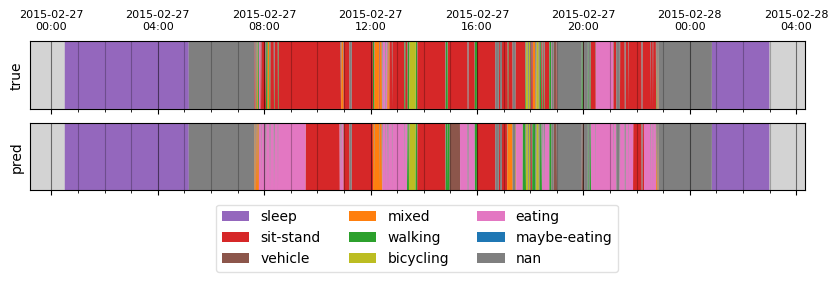

In [192]:
import importlib
importlib.reload(utils)
# Use the conveniently provided out-of-bag probability predictions from the
# random forest training process.
Y_train_prob = clf.oob_decision_function_  # out-of-bag probability predictions
labels = clf.classes_  # need this to know the label order of cols of Y_train_prob
hmm_params = utils.train_hmm(Y_train_prob, Y_train, labels)  # obtain HMM matrices/params
Y_test_pred_hmm = utils.viterbi(Y_test_pred, hmm_params)  # smoothing
print('\nClassifier performance -- HMM smoothing')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_hmm))

# Check again participant
mask = pid_test == 'P101'
fig, ax = utils.plot_compare(T_test[mask],
                             Y_test[mask],
                             Y_test_pred_hmm[mask])
fig.show()
